# **Sistema de Predição de Doenças Cardíacas Utilizando o Classificador Ingênuo de Bayes**

### **Grupo:**



*   Maria Clara Alves Acruchi - mcaa@cin.ufpe.br
*   Maria Luísa dos Santos Silva - mlss@cin.ufpe.br
*   Vinícius Sales Oliveira - vso2@cin.ufpe.br



## **Análise Exploratória dos Dados**

In [1]:
# importando as bibliotecas que serão utilizadas
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt


### **Importando Dataset**

Nesse projeto, utilizamos a base de dados "[Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/heart+disease)". 

Os dados estavam divididos em quatro arquivos diferentes, referentes aos diferentes hospitais em que foram coletados, então, para facilitar o acesso aos dados, unimos todos esses dados.

Em seguida, visto que as colunas não estavam nomeadas e vários dados estavam faltando, foi necessário renomear as colunas e substituir os valores ausentes (antes representados por "?") por NaN.

In [2]:
# importando dataset
df_cleveland_raw = pd.read_csv('processed.cleveland.data', header= None)
df_hungarian_raw = pd.read_csv('processed.hungarian.data', header= None)
df_switzerland_raw = pd.read_csv('processed.switzerland.data', header= None)
df_va_raw = pd.read_csv('processed.va.data', header= None)

# unindo os dados em uma única variável
df_raw = pd.concat([df_cleveland_raw,df_hungarian_raw,df_switzerland_raw,df_va_raw], axis=0)
table = df_raw.to_numpy()
table = table.T

# renomeando as colunas
names = {'age':table[0], 'sex':table[1], 'cp':table[2], 'trestbps':table[3],'chol':table[4], 'fbs':table[5], 'restcg':table[6],'thalach':table[7],'exang':table[8],'oldpeak':table[9],'slope':table[10],'ca':table[11] ,'thal':table[12],'num':table[13]}
df = pd.DataFrame(names)

# substituindo valores ausentes por NaN
df.replace("?",np.nan, inplace=True)



In [3]:
# visualizando a tabela com as colunas renomeadas
df.head()

,age,sex,cp,trestbps,chol,fbs,restcg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67.0,1.0,4.0,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67.0,1.0,4.0,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37.0,1.0,3.0,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41.0,0.0,2.0,130,204,0,2,172,0,1.4,1,0.0,3.0,0


### **Tipos das variáveis**


Visualizando as informações dos dados, percebemos que as colunas possuíam tipos diferentes, então, para facilitar a manipulação dos dados, todos os dados passaram a ser do tipo "float".

In [4]:
df.info() # visualizando informações da tabela

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    float64
 1   sex       920 non-null    float64
 2   cp        920 non-null    float64
 3   trestbps  861 non-null    object 
 4   chol      890 non-null    object 
 5   fbs       830 non-null    object 
 6   restcg    918 non-null    object 
 7   thalach   865 non-null    object 
 8   exang     865 non-null    object 
 9   oldpeak   858 non-null    object 
 10  slope     611 non-null    object 
 11  ca        309 non-null    object 
 12  thal      434 non-null    object 
 13  num       920 non-null    int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 100.8+ KB


In [5]:
for i in df.columns:
  df[i] = pd.to_numeric(df[i],downcast='float') # convertendo todas as colunas para o tipo float

In [6]:
df.info() # visualizando novamente as informações da tabela

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    float32
 1   sex       920 non-null    float32
 2   cp        920 non-null    float32
 3   trestbps  861 non-null    float32
 4   chol      890 non-null    float32
 5   fbs       830 non-null    float32
 6   restcg    918 non-null    float32
 7   thalach   865 non-null    float32
 8   exang     865 non-null    float32
 9   oldpeak   858 non-null    float32
 10  slope     611 non-null    float32
 11  ca        309 non-null    float32
 12  thal      434 non-null    float32
 13  num       920 non-null    float32
dtypes: float32(14)
memory usage: 50.4 KB


### **Valores ausentes e outliers**

Ao visualizar as informações da tabela, percebe-se que várias colunas possuem dados com valores que destoam muito dos demais e podem causar anomalias nos resultados obtidos, são os chamados *outliers*. Para resolver esse problema, todas as linhas da tabela que estejam a uma distância superior a 3 desvios padrão da média foram removidas.

No entanto, mesmo após essa remoção, algumas colunas possuíam valores inválidos. Por exemplo, a coluna que indica o colesterol total ("chol") possuía diversas linhas com valor "0", no entanto, não é possível ter valores tão baixos de colesterol. Por isso, substituímos estas linhas inválidas pela média de todos os valores da coluna. 

Além disso, a coluna que indicava o diagnóstico para doenças cardíacas (“num”) deveria possuir apenas valores binários (0 ou 1), mas nela existiam dados que não correspondiam a essa característica. Então, todas as linhas com esses valores inválidos foram removidas.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


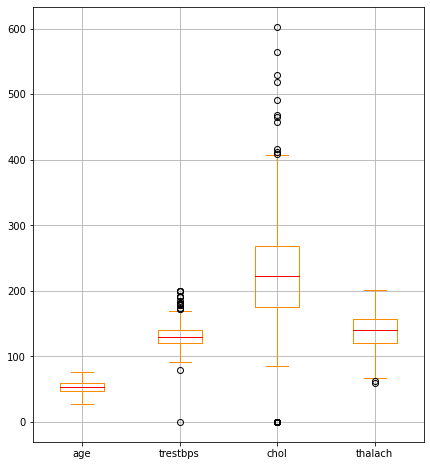

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


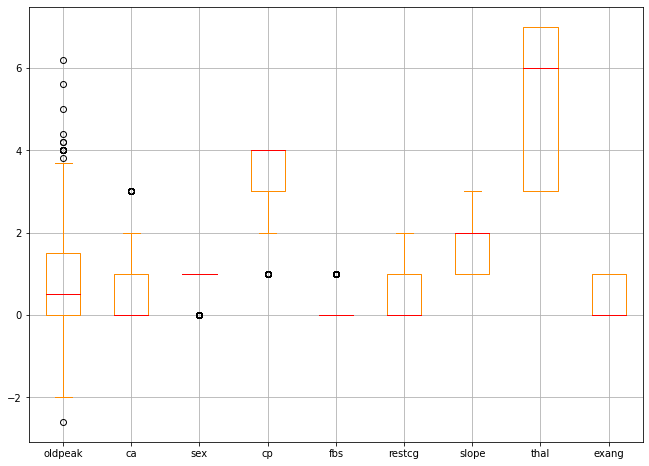

In [7]:
# visualizando os dados em boxplots
palette = ["#ff8c00", "#ffb268", "#ffd8b3", "#ffecd8"]

mask1 = ['age', 'trestbps','chol','thalach']
mask2 = ['oldpeak','ca', 'sex', 'cp', 'fbs', 'restcg','slope','thal', 'exang']
df1 = df[mask1]
df2 = df[mask2]
boxplot1 = df1.boxplot(figsize=(7,8), color=dict(boxes=palette[0], whiskers=palette[0], medians='r', caps=palette[0]))
plt.show()
boxplot2 = df2.boxplot(figsize=(11,8), color=dict(boxes=palette[0], whiskers=palette[0], medians='r', caps=palette[0]))
plt.show()

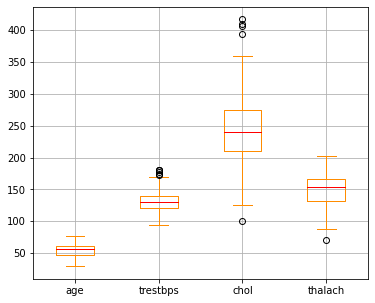

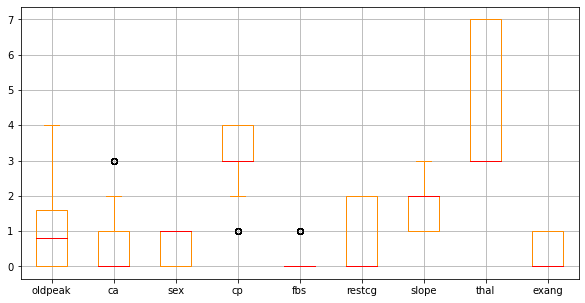

In [8]:
# remoção de outliers
z_scores = np.abs(stats.zscore(df,nan_policy='omit'))
filtered_entries = (z_scores < 3).all(axis=1)
df = df[filtered_entries]

# visualizando os dados em boxplots após a remoção
df1 = df[mask1]
df2 = df[mask2]
boxplot1 = df1.boxplot(figsize=(6,5), color=dict(boxes=palette[0], whiskers=palette[0], medians='r', caps=palette[0]))
plt.show()
boxplot2 = df2.boxplot(figsize=(10,5), color=dict(boxes=palette[0], whiskers=palette[0], medians='r', caps=palette[0]))
plt.show()

In [9]:
def transform_mean(x):
  mean = df[x].mean()
  df.loc[df[x]==0,x] = mean

transform_mean('chol') # alterando colesterol sérico de valor 0 para a média

In [10]:
df.loc[df['num']>1,'num'] = np.nan # transformando valores não booleanos em NaN, para remover posteriormente


Além disso, percebe-se que várias colunas possuem valores faltando. Para tratar esse problema, separamos os dados em dois tipos: categóricos e numéricos.

*  **Dados Numéricos** 



Os dados numéricos ausentes foram substituídos pela média dos dados da coluna.

In [11]:
numData = ['age', 'trestbps','chol','thalach','oldpeak','ca' ] # colunas cujos dados são numéricos
for i in numData:
  mean = df[i].mean()  # cálculo da média da coluna
  df[i] = df[i].fillna(mean) # substituindo valores NaN pela média

* **Dados categóricos**

Os dados categóricos ausentes foram substituídos pelo valor mais frequente (moda).

In [12]:
catData = ['sex', 'cp', 'fbs', 'restcg','slope','thal', 'exang']  # colunas cujos dados são categóricos, exceto a coluna de diagnóstico ("num")
for i in catData:
  mode = df[i].mode() # cálculo da moda da coluna
  df[i] = df[i].fillna(mode) # substituindo valores NaN pela moda

In [13]:
df = df.dropna() # removendo os valores não booleanos da coluna 'num' que foram transformados em NaN

In [14]:
df

,age,sex,cp,trestbps,chol,fbs,restcg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1.0
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1.0
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1.0
508,47.0,1.0,4.0,150.0,226.0,0.0,0.0,98.0,1.0,1.5,2.0,0.0,7.0,1.0


### **Representação gráfica dos dados**

Afim de visualizar melhor as distribuições dos dados, representamos graficamente cada uma das colunas do conjunto de dados. Para fazer essa representação gráfica, foi mantida a divisão entre dados numéricos e categóricos. Os dados numéricos foram representados por gráfico de barras e os dados categóricos em gráfico do tipo pizza.

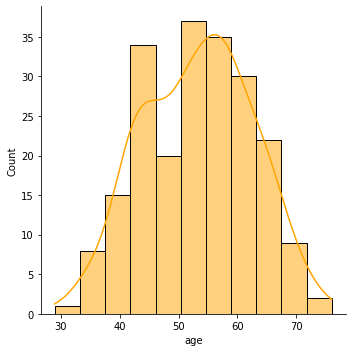

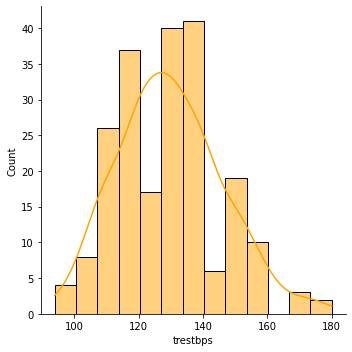

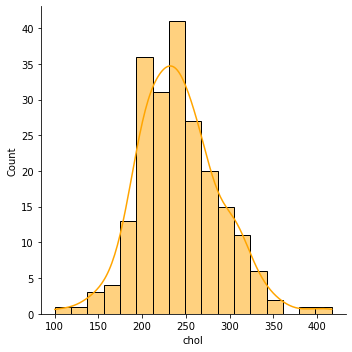

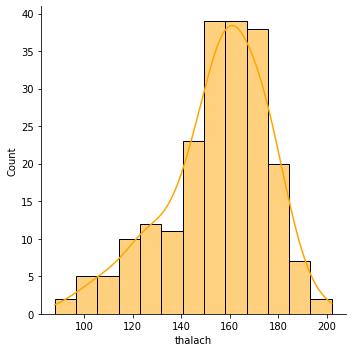

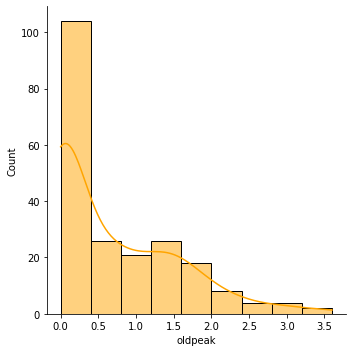

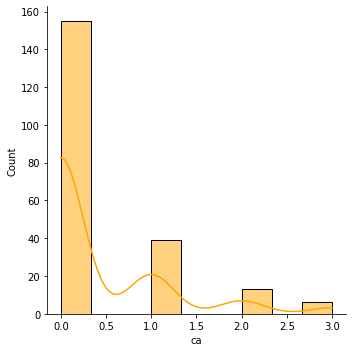

In [15]:
# dados numéricos
for i in numData:
  sns.displot(df[i], kde=True, color="orange") # representando dados numéricos em gráfico de barras

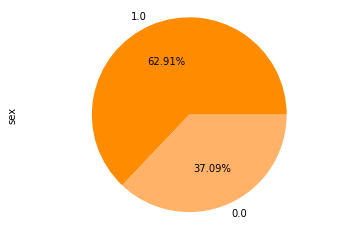

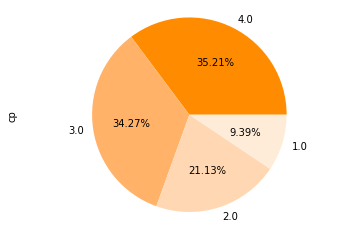

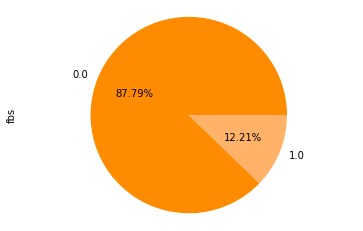

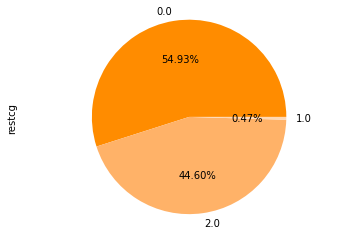

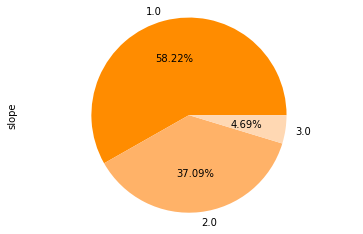

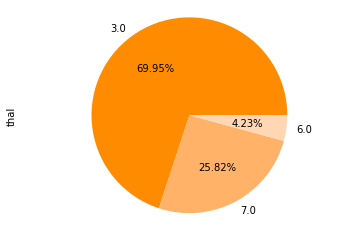

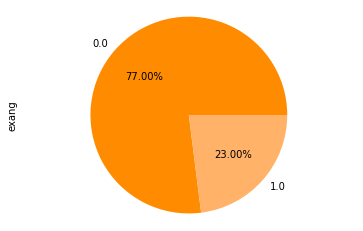

In [16]:
# dados categóricos
for i in catData:
  df[i].value_counts().plot(kind='pie', autopct='%.2f%%', colors=palette)  # representando dados categóricos em gráfico de pizza
  plt.axis('equal')
  plt.show()

## **Análise Estatística**

Para entender melhor as características dos pacientes com diagnóstico positivo para doença cardíaca, fizemos algumas análises sobre os dados. 

Para isso, filtramos do *Data Set* apenas esses pacientes e visualizamos a maneira que eles estão dispostos por sexo, idade, frequência cardíaca e pressão sanguínea, além de identificar a média dessas três últimas categorias.

In [17]:
# filtrando os que têm diagnóstico positivo
filter = (df['num']==1)
positive = df.loc[filter]

A média de idade das pessoas com diagnóstico positivo de doença cardíaca é 55.49 anos


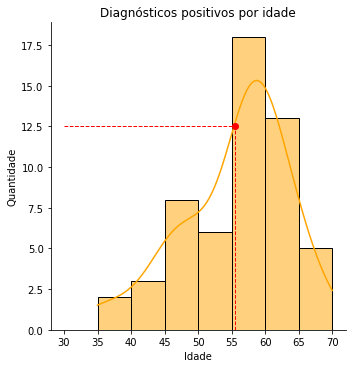

In [18]:
# cálculo da média de idade
meanAge = positive['age'].mean()
print("A média de idade das pessoas com diagnóstico positivo de doença cardíaca é", f'{meanAge:.2f}',"anos")

# exibindo em um gráfico a distribuição por idade e a média
sns.displot(positive['age'], kde=True, color="orange")
plt.plot(meanAge, 12.5, "o", color='red')
plt.plot([meanAge, meanAge], [0, 12.5], 'r--', lw=1, color='red')
plt.plot([30, meanAge], [12.5, 12.5], 'r--', lw=1, color='red')
plt.xlabel("Idade")
plt.ylabel("Quantidade")
plt.title('Diagnósticos positivos por idade')
plt.show()

A média da frequência cardíaca máxima das pessoas com diagnóstico positivo de doença cardíaca é: 143.75 bpm


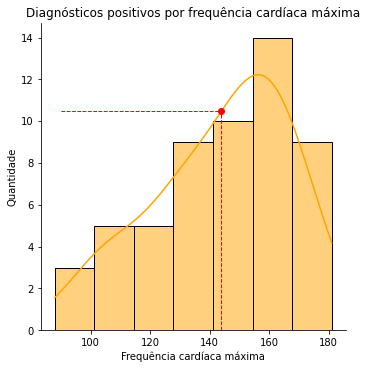

In [19]:
# cálculo da média de frequência cardíaca máxima
meanThalach = positive['thalach'].mean()
print("A média da frequência cardíaca máxima das pessoas com diagnóstico positivo de doença cardíaca é:", f'{meanThalach:.2f}',"bpm")

# exibindo em um gráfico a distribuição por frequência cardíaca máxima e a média
sns.displot(positive['thalach'], kde=True, color="orange")
plt.plot(meanThalach, 10.5, "o", color='red')
plt.plot([meanThalach, meanThalach], [0, 10.5], 'r--', lw=1, color='red')
plt.plot([90, meanThalach], [10.5, 10.5], 'r--', lw=1, color='red')
plt.xlabel("Frequência cardíaca máxima")
plt.ylabel("Quantidade")
plt.title('Diagnósticos positivos por frequência cardíaca máxima')
plt.show()

A média da pressão sanguínea em repouso das pessoas com diagnóstico positivo de doença cardíaca é: 132.27 mmHg


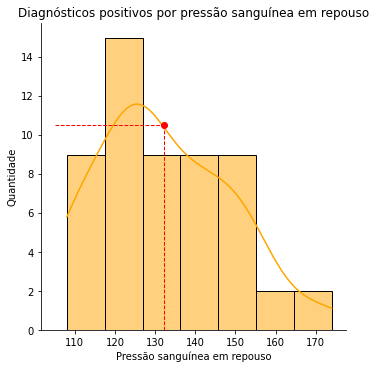

In [20]:

# cálculo da média de pressão sanguínea em repouso
meanTrestbps = positive['trestbps'].mean()
print("A média da pressão sanguínea em repouso das pessoas com diagnóstico positivo de doença cardíaca é:", f'{meanTrestbps:.2f}',"mmHg")

# exibindo em um gráfico a distribuição por pressão sanguínea em repouso e a média
sns.displot(positive['trestbps'], kde=True, color="orange")
plt.plot(meanTrestbps, 10.5, "o", color='red')
plt.plot([meanTrestbps, meanTrestbps], [0, 10.5], 'r--', lw=1, color='red')
plt.plot([105, meanTrestbps], [10.5, 10.5], 'r--', lw=1, color='red')
plt.xlabel("Pressão sanguínea em repouso")
plt.ylabel("Quantidade")
plt.title('Diagnósticos positivos por pressão sanguínea em repouso')
plt.show()

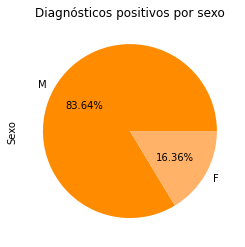

In [21]:
# exibindo em um gráfico a distribuição por sexo
positive["sex"].value_counts().plot(kind='pie', autopct='%.2f%%', labels=["M", "F"], colors = palette)
plt.title('Diagnósticos positivos por sexo')
plt.ylabel("Sexo")
plt.show()

## **Experimentos e Testes**

In [22]:
pip install Boruta


     |████████████████████████████████| 56 kB 2.5 MB/s 


In [23]:
# importando as bibliotecas que serão utilizadas:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from subprocess import call
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

### **Funções Auxiliares**

Em nossos testes e experimentos, utilizamos duas funções.

A função `getResults` é usada para visualizar os resultados do modelo, exibindo a matriz de confusão e os indicadores.

A função `process_train` para treinar um modelo Naïve Bayes dado um dataset e exibir os resultados utilizando a função anterior.

In [24]:
def getResults(x,y,x_test, y_test, model):
  predicted = model.predict(x_test)
  scores = cross_val_score(model, x, y, cv=5)
  print("Acurácia = %0.4f" %(accuracy_score(y_test, predicted)))
  print("\nValidação cruzada:","\nAcurácia média = %0.4f\nDesvio padrão = %0.4f"%(scores.mean(),scores.std()))
  cm = confusion_matrix(y_test, predicted)
  sns.heatmap(cm, center=True, cmap="Oranges")
  plt.show()
  print(pd.DataFrame(
    confusion_matrix(y_test, predicted),
    columns=['Previsão Diagnóstico Negativo', 'Previsão Diagnóstico Positivo'],
    index=['Verdadeiro Negativo', 'Verdadeiro Positivo']
  ))
  report = classification_report(y_test, predicted)
  print("\n\n\n")
  print(report)

In [25]:
def process_train(df,stratified = False):
  x = df.drop('num', axis=1) # nova tabela com todas as colunas exceto a do diagnóstico de doença ('num')
  y = df['num'] # coluna do diagnóstico 
  if stratified==False:
    X_train, X_test, y_train, y_test =train_test_split(x, y, random_state=42, test_size=0.3) # separando em teste e treino
  else:
    X_train, X_test, y_train, y_test =train_test_split(x, y, random_state=42, test_size=0.3, stratify=y)
  gnb = GaussianNB()
  y_pred =gnb.fit(X_train,y_train).predict(X_test) # treina e faz previsão
  getResults(x,y,X_test,y_test,gnb) # exibe resultados

### **Experimento 1**

Nesse experimento, iremos treinar e checar a performance do algoritmo para toda a base de dados, sem modificação.

Acurácia = 0.7031

Validação cruzada: 
Acurácia média = 0.7843
Desvio padrão = 0.0570


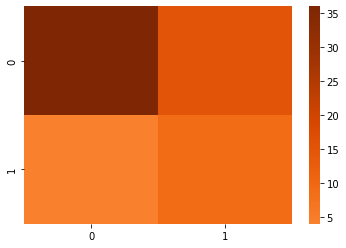

                     Previsão Diagnóstico Negativo  Previsão Diagnóstico Positivo
Verdadeiro Negativo                             36                             15
Verdadeiro Positivo                              4                              9




              precision    recall  f1-score   support

         0.0       0.90      0.71      0.79        51
         1.0       0.38      0.69      0.49        13

    accuracy                           0.70        64
   macro avg       0.64      0.70      0.64        64
weighted avg       0.79      0.70      0.73        64



In [26]:
process_train(df)

### **Experimento 2**

Nesse experimento, iremos estratificar a base de dados e checar se essa divisão em grupos homogêneos impacta a performance.

Acurácia = 0.6875

Validação cruzada: 
Acurácia média = 0.7843
Desvio padrão = 0.0570


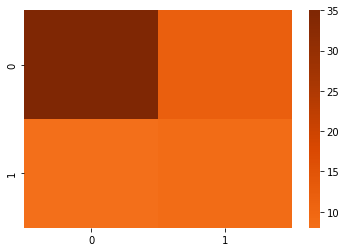

                     Previsão Diagnóstico Negativo  Previsão Diagnóstico Positivo
Verdadeiro Negativo                             35                             12
Verdadeiro Positivo                              8                              9




              precision    recall  f1-score   support

         0.0       0.81      0.74      0.78        47
         1.0       0.43      0.53      0.47        17

    accuracy                           0.69        64
   macro avg       0.62      0.64      0.63        64
weighted avg       0.71      0.69      0.70        64



In [27]:
process_train(df,True)

A precisão da classe de diagnóstico positivo diminuiu e o recall aumentou. Já na classe de diagnóstico negativo, a precisão aumentou e o recall diminuiu. É o tradeoff de precisão/recall.

Para os devidos fins, a nossa métrica mais importante é o recall, já que **falsos diagnósticos negativos são mais prejudiciais que falsos diagnósticos positivos**. E vemos que o número de falsos negativos diminuiu de 15 para 12.

Portanto:

*   Estratificação melhorou a precisão nos grupos menos hegemônico (diagnóstico positivo), sob o custo de piorar a precisão do grupo hegemônico (diagnóstico negativo)
*   Piorou o recall da classe de diagnóstico positivo e melhorou o recall da classe de diagnóstico negativo.
*   Temos menos falsos negativos que na base de dados não estratificada.



### **Experimento 3**

Nesse experimento, buscaremos melhorar a performance do modelo através da seleção de features (características).

Iremos usar um algoritmo de seleção de Features baseado no modelo de Random Forest - o algoritmo Boruta. Esse algoritmo treina um modelo de random forest e nos retorna - ou tenta retornar - o conjunto de features que performam melhor.

In [28]:
# boruta

x,y = df.drop('num', axis=1), df['num']

metamodel = RandomForestClassifier(max_depth = 3)
feature_selector = BorutaPy(metamodel, n_estimators='auto', verbose=False, random_state=28)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

x_train=x_train.to_numpy()

y_train=y_train.ravel()

feature_selector.fit(x_train, y_train)

BorutaPy(estimator=RandomForestClassifier(max_depth=3, n_estimators=115,
                                          random_state=RandomState(MT19937) at 0x7FD9FB73DD10),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FD9FB73DD10, verbose=False)

In [29]:
feature_selector.support_

array([ True, False,  True, False, False, False, False,  True,  True,
        True, False, False,  True])

In [30]:
x.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restcg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [31]:
df_filtered = df.copy()
chosen_features = []
for i,val in enumerate(feature_selector.support_):
  if val == True:
    chosen_features.append(x.columns[i])
df_filtered = df_filtered[chosen_features]
df_filtered['num'] = y
df_filtered

,age,cp,thalach,exang,oldpeak,thal,num
0,63.0,1.0,150.0,0.0,2.3,6.0,0.0
2,67.0,4.0,129.0,1.0,2.6,7.0,1.0
3,37.0,3.0,187.0,0.0,3.5,3.0,0.0
4,41.0,2.0,172.0,0.0,1.4,3.0,0.0
5,56.0,2.0,178.0,0.0,0.8,3.0,0.0
...,...,...,...,...,...,...,...
297,57.0,4.0,123.0,1.0,0.2,7.0,1.0
298,45.0,1.0,132.0,0.0,1.2,7.0,1.0
301,57.0,2.0,174.0,0.0,0.0,3.0,1.0
508,47.0,4.0,98.0,1.0,1.5,7.0,1.0


Acurácia = 0.6406

Validação cruzada: 
Acurácia média = 0.7558
Desvio padrão = 0.0524


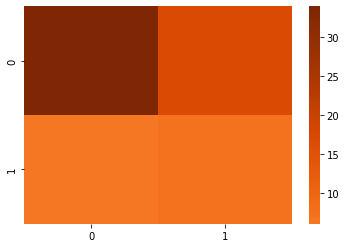

                     Previsão Diagnóstico Negativo  Previsão Diagnóstico Positivo
Verdadeiro Negativo                             34                             17
Verdadeiro Positivo                              6                              7




              precision    recall  f1-score   support

         0.0       0.85      0.67      0.75        51
         1.0       0.29      0.54      0.38        13

    accuracy                           0.64        64
   macro avg       0.57      0.60      0.56        64
weighted avg       0.74      0.64      0.67        64



In [32]:
process_train(df_filtered)

Vemos que, em relação ao experimento 2, temos que a precissão da classe de diagnóstico negativo aumentou um pouco e a da classe de diagnóstico positivo diminuiu bruscamente. O recall piorou para o diagnóstico negativo e melhorou para o diagnóstico positivo. Vemos que temos mais falsos negativos nesse experimento que nos últimos dois.

Portanto:


*   O modelo com essas escolhas de variáveis e sem estratificação, para os devidos fins, performa pior que os outros experimentos, já que possui maior quantidade de falsos negativos)
*   O aumento do recall e da precisão nas classes diagnóstico positivo e diagnóstico negativo, respectivamente é irrisório em relação a diminuição dos outros indices.



### **Experimento 4**


Nesse experimento, iremos usar as features escolhidas anteriormente, mas estratificando os dados.

Acurácia = 0.7344

Validação cruzada: 
Acurácia média = 0.7558
Desvio padrão = 0.0524


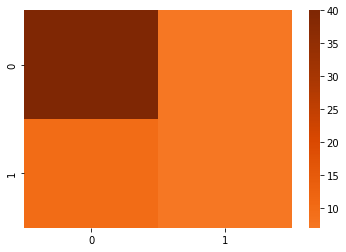

                     Previsão Diagnóstico Negativo  Previsão Diagnóstico Positivo
Verdadeiro Negativo                             40                              7
Verdadeiro Positivo                             10                              7




              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82        47
         1.0       0.50      0.41      0.45        17

    accuracy                           0.73        64
   macro avg       0.65      0.63      0.64        64
weighted avg       0.72      0.73      0.73        64



In [33]:
process_train(df_filtered, True)

Nesse experimento, vemos de início que temos o menor número de falsos negativos dos experimentos até então. O recall dos diagnóstico negativo aumentou em detrimento da precisão, ocorreu o inverso na classe de diagnóstico positivo, onde a precisão aumetou em detrimento do recall.

Portanto:

*   A estratificação, para os devidos fins, afetou positivamente o modelo.
*   Temos a menor quantidade de falsos negativos dos experimentos.

